In [1]:
# import mplfinance as mpf
import pandas as pd
import ta
import optuna
import time
import numpy as np
from multiprocessing import Pool
from itertools import combinations, chain
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt

In [2]:
from utils.utils import plot_candle_chart, file_features, buy_signals_1d, buy_signals_1h, buy_signals_1m, buy_signals_5m
from utils.utils import sell_signals_1d, sell_signals_1h, sell_signals_1m, sell_signals_5m, plot_buy_sell_signals, data_fun
from utils.utils import backtest, plot_operations_history, port_value_plot, plot_cash, cash_portvalue_plot, pasive_portvalue_plot

# Machin Learning

Nuestro proyecto de análisis de machine learning se centra en la exploración y modelado de conjuntos de validación proporcionados durante las primeras etapas del curso. En particular, nos sumergimos en la información financiera de la empresa AAPL (Apple Inc.), examinando meticulosamente sus datos de precios de cierre, máximos, mínimos, y otros indicadores relevantes.

In [3]:
data_1d = data_fun("data/aapl_1d_test.csv")
data_1h = data_fun("data/aapl_1h_test.csv")
data_1m = data_fun("data/aapl_1m_test.csv")
data_5m = data_fun("data/aapl_5m_test.csv")
data_1d.head()

,Date,Open,High,Low,Close,Adjusted_close,Volume
0,2021-02-17,131.25,132.22,129.47,130.84,128.7615,97918500
1,2021-02-18,129.20,130.00,127.41,129.71,127.6494,96856700
2,2021-02-19,130.24,130.71,128.80,129.87,127.8069,87668800
3,2021-02-22,128.01,129.72,125.60,126.00,123.9984,103916400
4,2021-02-23,123.76,126.71,118.39,125.86,123.8606,158273000


    Fecha: Indica la fecha en que se registraron los datos de precios de las acciones de Apple. Es esencial para seguir la evolución del precio a lo largo del tiempo y detectar patrones y tendencias.

    Apertura: Es el primer precio al que se negociaron las acciones de Apple en el día. Proporciona una indicación inicial de la dirección en que el precio puede moverse durante la jornada.

    Alto: Es el precio más alto alcanzado durante el día de negociación para las acciones de Apple. Indica el máximo alcanzado y la fuerza alcista del mercado.

    Bajo: Es el precio más bajo alcanzado durante el día de negociación. Indica el mínimo y la presión de venta en el mercado.

    Cierre: Es el último precio al que se negociaron las acciones en el día. Es uno de los más importantes, reflejando el valor final al que los inversores están dispuestos a comprar o vender las acciones.

    Cierre Ajustado: Considera eventos corporativos que afecten el precio de las acciones, como divisiones de acciones o dividendos. Ofrece una medida más precisa del rendimiento del precio de las acciones.

    Volumen: Indica la cantidad total de acciones de Apple negociadas durante el día. Puede señalar la fuerza detrás de los movimientos de precios: un alto volumen sugiere mayor interés y actividad, mientras que un bajo volumen puede indicar menor participación y volatilidad.

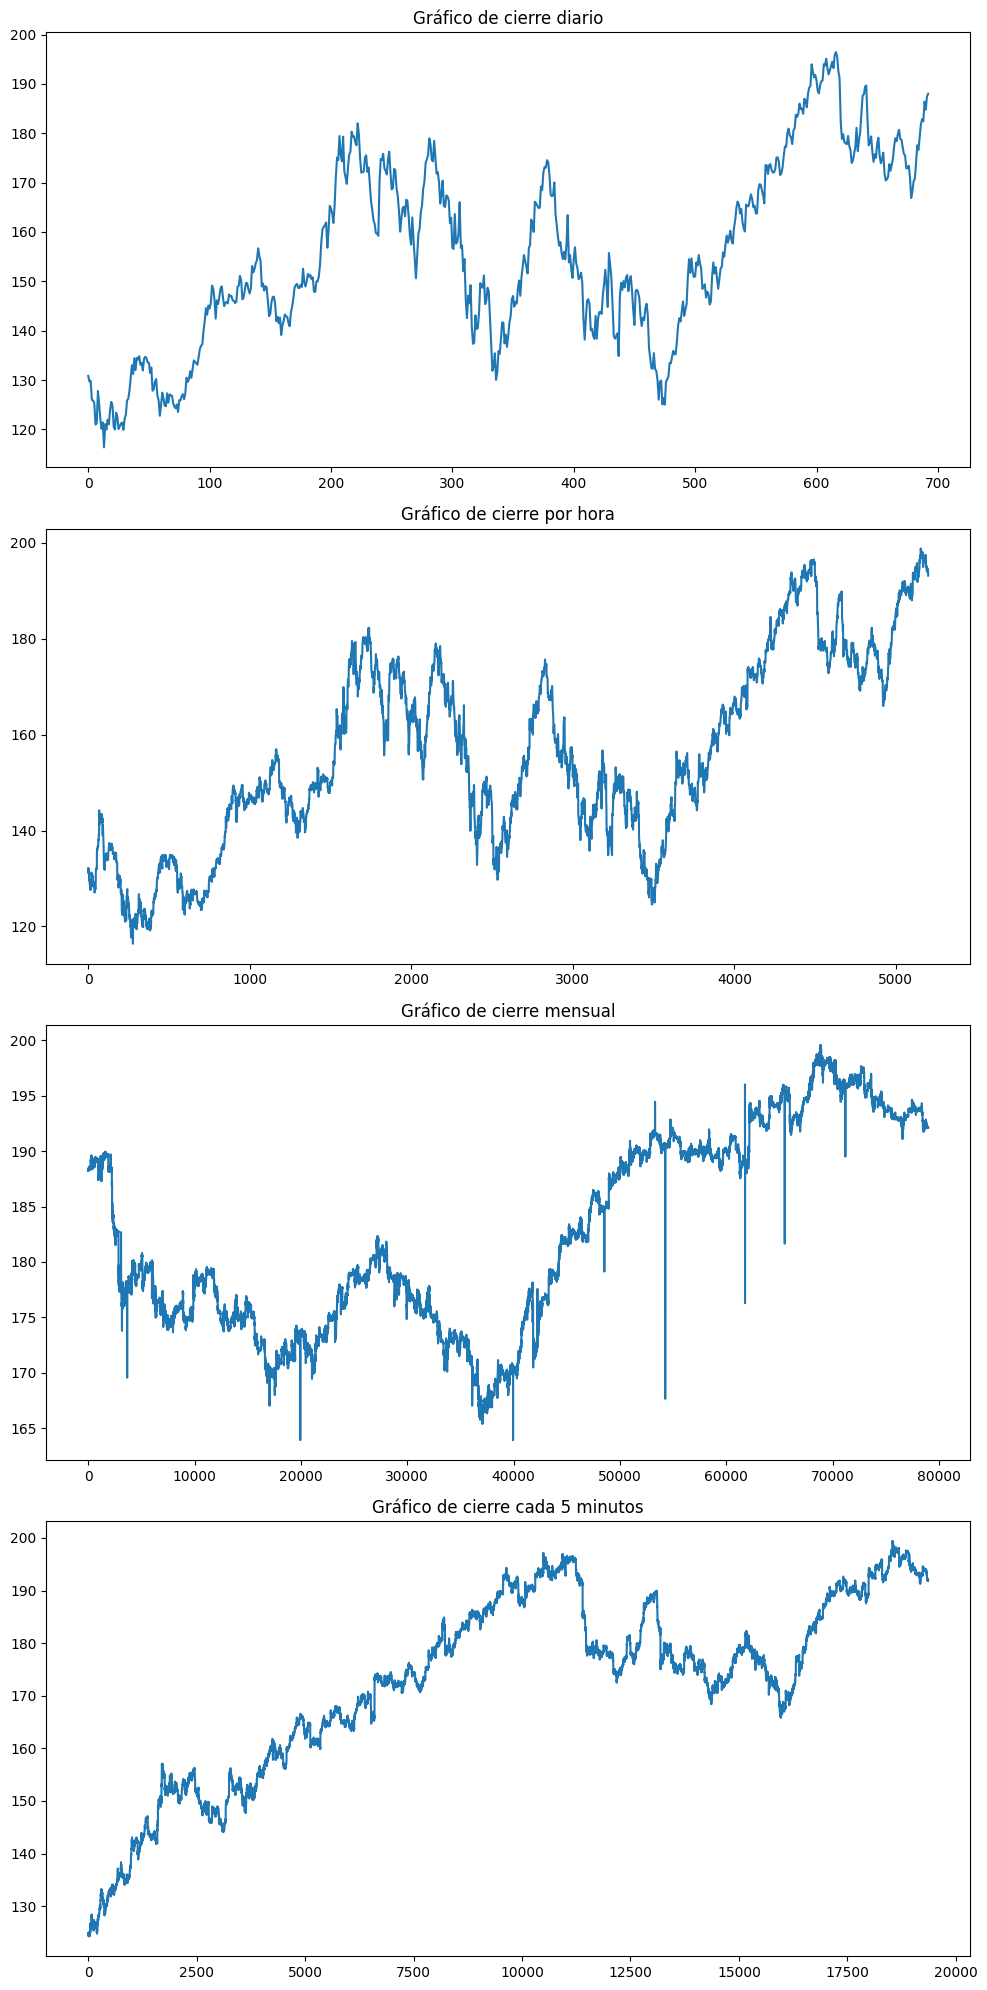

In [4]:
fig, axs = plt.subplots(4, figsize=(10, 20))
data_1d['Close'].plot(ax=axs[0])
axs[0].set_title('Gráfico de cierre diario')
data_1h['Close'].plot(ax=axs[1])
axs[1].set_title('Gráfico de cierre por hora')
data_1m['Close'].plot(ax=axs[2])
axs[2].set_title('Gráfico de cierre mensual')
data_5m['Close'].plot(ax=axs[3])
axs[3].set_title('Gráfico de cierre cada 5 minutos')
plt.tight_layout()
plt.show()

Las acciones de Apple (AAPL) han experimentado un crecimiento significativo en las últimas décadas. Desde su salida a bolsa en 1980, el precio de las acciones de Apple ha tenido varias tendencias alcistas y correcciones, pero en general ha mostrado una tendencia ascendente a largo plazo.

La variación del precio de las acciones de Apple a menudo está relacionada con el rendimiento de sus productos y la innovación tecnológica. El lanzamiento de nuevos productos exitosos, como el iPhone, iPad, Mac y servicios como Apple Music y Apple TV+, puede impulsar el precio de las acciones.

## Modelos de Machin Learning

* 1. Logistic Regression:

Definición: Logistic Regression es un modelo de clasificación que se emplea para predecir la probabilidad de ocurrencia de un evento binario.
Características: Se trata de un modelo lineal que utiliza la función logística para calcular las probabilidades.
Hiperparámetros: Entre los hiperparámetros más relevantes se encuentran el parámetro de regularización (C), que controla la fuerza de la regularización, y la técnica de regularización (L1 o L2).
Funcionamiento: Logistic Regression calcula la probabilidad de que una instancia pertenezca a una clase utilizando la función logística, y posteriormente aplica un umbral para clasificar las instancias en una clase u otra.

* 2. Support Vector Machine (SVM):

Definición: SVM es un modelo de aprendizaje supervisado que se utiliza tanto para clasificación como para regresión.
Características: SVM busca encontrar el hiperplano que mejor separa las clases en el espacio de características.
Hiperparámetros: Entre los hiperparámetros clave se incluyen el tipo de kernel (lineal, polinomial, radial, etc.), el parámetro de regularización (C) y el parámetro del kernel (gamma).
Funcionamiento: SVM mapea los datos de entrada a un espacio de características de alta dimensión donde busca encontrar el hiperplano que maximiza el margen entre las clases.

* 3. XGBoost:

Definición: XGBoost es una implementación de Gradient Boosting que se utiliza ampliamente en competiciones de ciencia de datos y machine learning.
Características: XGBoost es altamente eficiente y escalable, y puede manejar conjuntos de datos grandes con millones de instancias y características.
Hiperparámetros: Algunos hiperparámetros clave incluyen la tasa de aprendizaje (learning rate), el número de árboles (n_estimators), la profundidad máxima del árbol (max_depth) y la función de pérdida.
Funcionamiento: XGBoost funciona mediante la construcción secuencial de árboles de decisión débiles, donde cada árbol se entrena para corregir los errores del modelo anterior.

## Definicion de variables independientes y dependiente

Con los conjuntos de datos proporcionados, se procede a la definición de nuevos dataframes que contienen las variables independientes junto con la variable dependiente ("response") para su posterior entrenamiento. Es importante destacar que se generan dos conjuntos de datos distintos: uno referente a las transacciones de compra y no compra, y otro relativo a las transacciones de venta y no venta. 

In [5]:
dataresult_long_1d_test = file_features("data/aapl_1d_test.csv", ds_type = "buy")
dataresult_long_1d_test = dataresult_long_1d_test.dropna()
dataresult_short_1d_test = file_features("data/aapl_1d_test.csv", ds_type = "sell")
dataresult_short_1d_test = dataresult_short_1d_test.dropna()
dataresult_short_1d_test.head()

,CMF,RSI,Volatility,Close_Lag0,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4,Close_Lag5,Response
0,-0.150397,41.907869,2.75,130.84,133.19,135.37,135.13,135.39,136.01,True
1,0.003010,39.714419,2.59,129.71,130.84,133.19,135.37,135.13,135.39,True
2,0.084205,40.191750,1.91,129.87,129.71,130.84,133.19,135.37,135.13,True
3,-0.029780,33.319745,4.12,126.00,129.87,129.71,130.84,133.19,135.37,True
4,0.112971,33.099266,8.32,125.86,126.00,129.87,129.71,130.84,133.19,True


In [6]:
dataresult_long_1m_test = file_features("data/aapl_1m_test.csv", ds_type = "buy")
dataresult_long_1m_test = dataresult_long_1m_test.dropna()
dataresult_short_1m_test = file_features("data/aapl_1m_test.csv", ds_type = "sell")
dataresult_short_1m_test = dataresult_short_1m_test.dropna()
dataresult_short_1m_test.head()

,CMF,RSI,Volatility,Close_Lag0,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4,Close_Lag5,Response
0,-0.672169,47.734613,0.03,188.22,188.19,188.20,188.25,188.23,188.19,False
1,-0.610246,51.069808,0.05,188.25,188.22,188.19,188.20,188.25,188.23,False
2,-0.607026,49.926144,0.00,188.24,188.25,188.22,188.19,188.20,188.25,False
3,-0.649422,49.926144,0.00,188.24,188.24,188.25,188.22,188.19,188.20,False
4,-0.419170,51.193736,0.04,188.25,188.24,188.24,188.25,188.22,188.19,False


In [7]:
dataresult_long_1h_test = file_features("data/aapl_1h_test.csv", ds_type = "buy")
dataresult_long_1h_test = dataresult_long_1h_test.dropna()
dataresult_short_1h_test = file_features("data/aapl_1h_test.csv", ds_type = "sell")
dataresult_short_1h_test = dataresult_short_1h_test.dropna()
dataresult_short_1h_test.head()

,CMF,RSI,Volatility,Close_Lag0,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4,Close_Lag5,Response
0,-0.141211,60.423211,1.589905,132.154998,131.070007,130.380004,130.860000,131.210006,130.616806,True
1,-0.102683,54.168745,1.880005,131.115005,132.154998,131.070007,130.380004,130.860000,131.210006,True
2,0.001769,55.871543,1.320008,131.475006,131.115005,132.154998,131.070007,130.380004,130.860000,True
3,0.053753,57.288510,0.769699,131.773498,131.475006,131.115005,132.154998,131.070007,130.380004,True
4,0.133904,58.333594,0.580002,131.990005,131.773498,131.475006,131.115005,132.154998,131.070007,True


In [8]:
dataresult_long_5m_test = file_features("data/aapl_5m_test.csv", ds_type = "buy")
dataresult_long_5m_test = dataresult_long_5m_test.dropna()
dataresult_short_5m_test = file_features("data/aapl_5m_test.csv", ds_type = "sell")
dataresult_short_5m_test = dataresult_short_5m_test.dropna()
dataresult_short_5m_test.head()

,CMF,RSI,Volatility,Close_Lag0,Close_Lag1,Close_Lag2,Close_Lag3,Close_Lag4,Close_Lag5,Response
0,-0.238759,30.798433,0.160003,124.730003,124.742500,124.599899,124.849998,124.966003,125.230003,True
1,-0.254607,35.366789,0.349998,124.930000,124.730003,124.742500,124.599899,124.849998,124.966003,True
2,-0.185629,36.275150,0.235001,124.970100,124.930000,124.730003,124.742500,124.599899,124.849998,True
3,-0.136034,34.026357,0.235000,124.794998,124.970100,124.930000,124.730003,124.742500,124.599899,True
4,-0.101998,29.185824,0.520004,124.360000,124.794998,124.970100,124.930000,124.730003,124.742500,True


# Para el análisis de machine learning propuesto, se establece una metodología que se sustenta en los siguientes puntos:
    
* Variables Independientes y Lagging:

La metodología se apoya en variables independientes, específicamente el precio de cierre (close price) de los activos financieros. Se genera un enfoque de lagging, el cual implica la creación de nuevas columnas que contienen información rezagada en el tiempo. Estas columnas con rezagos ayudan a capturar tendencias y patrones temporales en los datos históricos.
La inclusión de rezagos en el conjunto de datos es fundamental para mejorar el poder predictivo del modelo. Al considerar información pasada, el modelo puede identificar correlaciones y patrones que podrían afectar el comportamiento futuro de los precios.
Indicadores Técnicos CMF y RSI:

* Se integran indicadores técnicos clave en el análisis, como el Money Flow Index (CMF) y el Relative Strength Index (RSI).

Estos indicadores son herramientas comúnmente utilizadas en el análisis técnico de los mercados financieros.
El CMF es un indicador que evalúa el flujo de dinero dentro o fuera de un activo durante un período determinado, ayudando a identificar posibles cambios en la tendencia de precios.
Por otro lado, el RSI es un indicador que mide la fuerza y la velocidad del movimiento de los precios, permitiendo identificar condiciones de sobrecompra o sobreventa en un mercado.
La inclusión de estos indicadores en el análisis brinda al modelo una perspectiva más amplia sobre la dinámica del mercado y puede ayudar a identificar oportunidades de trading potenciales.
Volatilidad:

* La volatilidad es un componente crítico en el análisis de los mercados financieros. 

Se calcula como la medida de la variabilidad de los precios de un activo durante un período de tiempo específico. 
La inclusión de la volatilidad en el análisis permite al modelo tener en cuenta la incertidumbre y el riesgo asociado con el comportamiento de los precios.
Además, la volatilidad puede proporcionar información valiosa sobre la estabilidad y la dirección futura de los precios, lo que contribuye significativamente al poder predictivo del modelo.

* Variable dependiente (de respuesta)

Para la variable dependiente, la lógica subyacente se estructura de la siguiente manera: al comparar el precio de cierre actual con el precio de cierre de hace 10 días, se determina la acción a seguir en el mercado. Específicamente, si el precio de cierre actual es mayor que el de hace 10 días, se ejecuta una acción de venta; por el contrario, si es menor, se procede con una acción de compra. Este enfoque se aplica de manera análoga tanto para los conjuntos de datos correspondientes a las transacciones de compra como a las de venta. La definición y aplicación de esta lógica constituyen un aspecto crítico en la construcción de modelos de machine learning destinados a la predicción de movimientos financieros.

In [9]:
global_buy_signals_1d_long = buy_signals_1d(dataresult_long_1d_test)
global_sell_signals_1d_short = sell_signals_1d(dataresult_short_1d_test)
global_buy_signals_1h_long = buy_signals_1h(dataresult_long_1h_test)
global_sell_signals_1h_short = sell_signals_1h(dataresult_short_1h_test)
global_buy_signals_1m_long = buy_signals_1m(dataresult_long_1m_test)
global_sell_signals_1m_short = sell_signals_1m(dataresult_short_1m_test)
global_buy_signals_5m_long = buy_signals_5m(dataresult_long_5m_test)
global_sell_signals_5m_short = sell_signals_5m(dataresult_short_5m_test)
global_sell_signals_5m_short

,predicciones_lr,predicciones_svm,predicciones_xgboost
0,False,True,True
1,False,True,True
2,False,True,True
3,False,True,True
4,False,True,True
...,...,...,...
19359,False,True,False
19360,False,True,False
19361,False,True,False
19362,False,True,False


## Procesamiento y Fine Tuning

Tras la definición de la variable dependiente y la lógica de operación establecida, el proyecto de análisis de aprendizaje automático avanza hacia la fase de preparación de datos y ajuste de modelos. Este proceso se inicia con la partición de los conjuntos de datos en conjuntos de entrenamiento y pruebas, lo que proporciona una base sólida para evaluar el rendimiento de los modelos de aprendizaje automático.

Una vez divididos los conjuntos de datos, se da inicio al proceso de ajuste de hiperparámetros, también conocido como finetuning. En este contexto, el finetuning implica la optimización de los parámetros de los modelos de aprendizaje automático con el fin de identificar las combinaciones óptimas que maximicen el rendimiento predictivo del modelo.

Durante el proceso de finetuning, se exploran y ajustan los hiperparámetros de los modelos, tales como la tasa de aprendizaje, la profundidad del árbol de decisión, el número de vecinos en el algoritmo de vecinos más cercanos, entre otros. Esta exploración exhaustiva permite determinar qué combinaciones de hiperparámetros son más efectivas para cada modelo en particular.

A continuacion se presenta la grafica de como se ven las opciones de compra o venta ya con los parametros optimos, y la mejor estrategia, esto siguien el precio de cierre de la accion. 

### 1 Día
Por la cantidad de datos que hay en el dataset nos encontramos con un volumen "bajo" de transacciones, a simple vista podemos ver que las operaciones de ventas dominan por encima de las de compra. Podemos observar que durante las subidas va comprando de forma periodica hasta llegar al cambio de tendencia y comienza con las operaciones de compra y asi sucesivamente, podria decirse que se parece a un bot que opera a traves de cuadriculas.

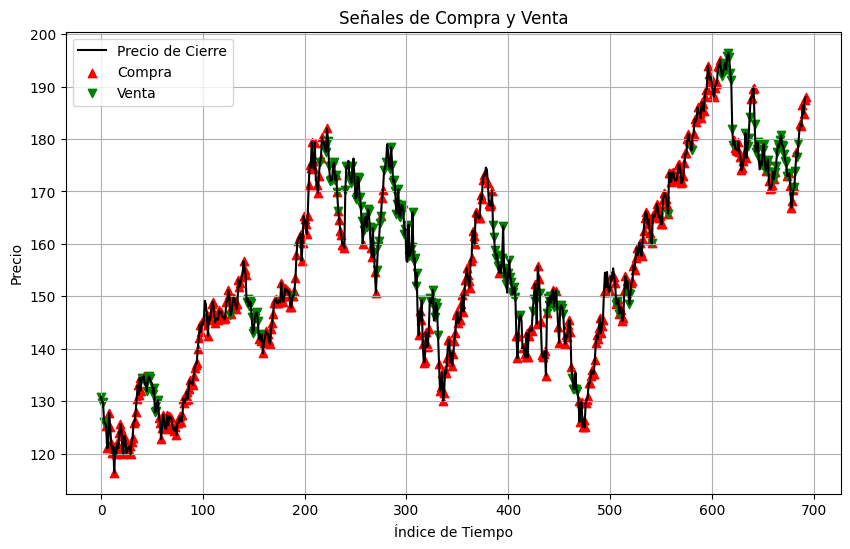

In [10]:
plot_buy_sell_signals(global_buy_signals_1d_long, global_sell_signals_1d_short, dataresult_short_1d_test)

### 1 Hora
Las grafica se asemeja a la del dia 1, pero las operaciones ya cambian, podemos observar que la operaciones se nivelan mas entre compra y venta, por lo que ya no podemos notar que lado es mas usado por el modelo. Notemos que la tendencia es la misma, en las subidas suele hacer mas operaciones de venta y viceversa, en las bajadas tiene mas operaciones de compra. Pareciendose tambien a un bot de cuadricula para operar el mercado.

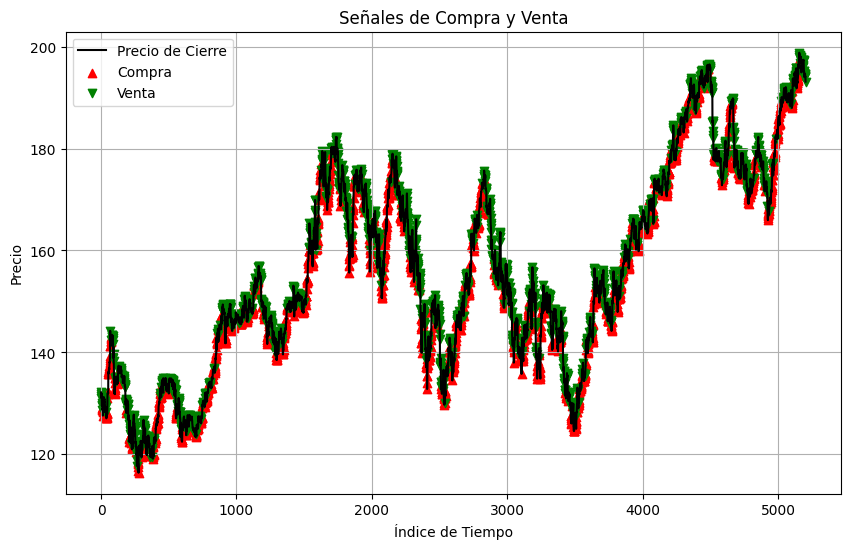

In [11]:
plot_buy_sell_signals(global_buy_signals_1h_long, global_sell_signals_1h_short, dataresult_short_1h_test)

### 1 Minuto
En esta dataset, ya no es parecido a un bot de cuadricula, al menos no a simple vista. El numero de operaciones ha aumentado en comparacion a los otros dos datasets, por obvias razones, hay mas datos y en "time frames" mas cortos encuentra mas oportunidades de compra/venta. Lo unico que me puede llegarnos a preocupar son los picos que se forman, pero quiero pensar que es un error en el dataset, a menos de que el precio haya caido/aumentado de maneras tan abruptas en esos periodos de tiempo.

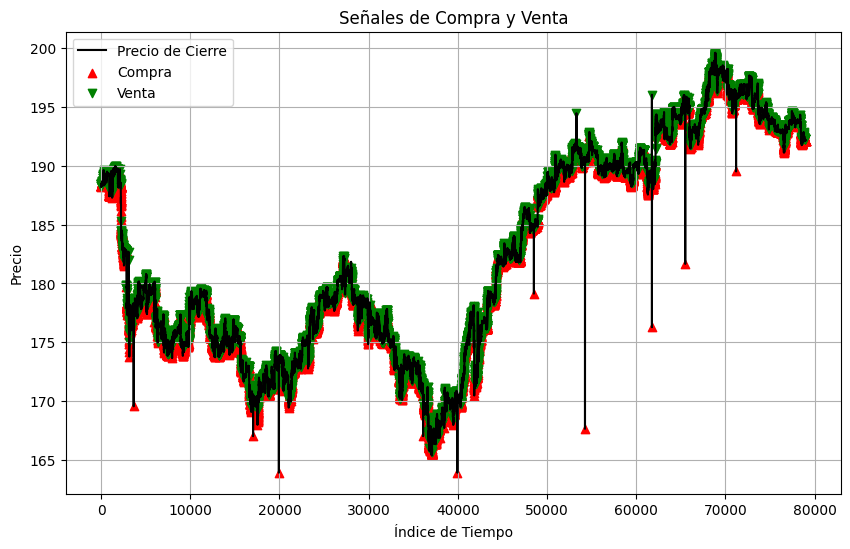

In [12]:
plot_buy_sell_signals(global_buy_signals_1m_long, global_sell_signals_1m_short, dataresult_short_1m_test)

### 5 Minutos
En algunos momentos se puede apreciar la observacion hecha en los datasets de un dia y una hora, pero al ser tantas operaciones no se puede ser tan claro en las afirmaciones porque me parece que las de compra se trasponen a las de venta (los colores en pocas palabras).

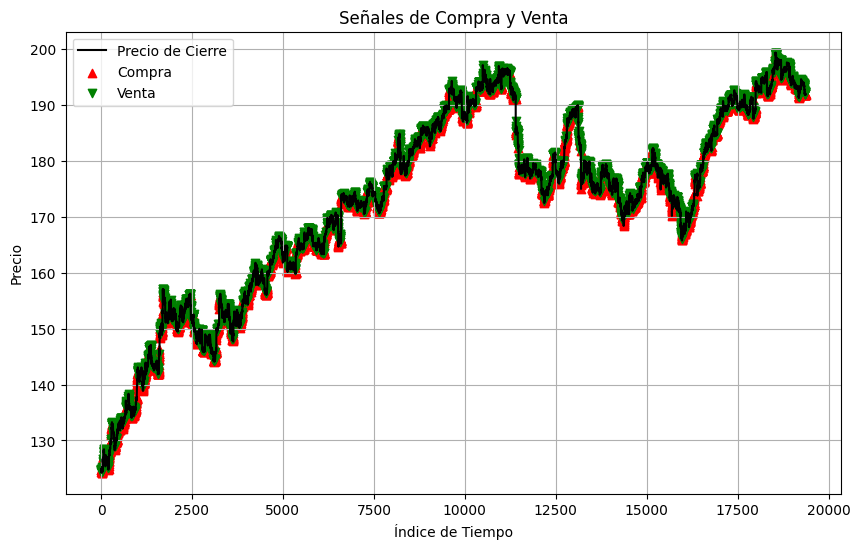

In [13]:
plot_buy_sell_signals(global_buy_signals_5m_long, global_sell_signals_5m_short, dataresult_short_5m_test)

## Optimizacion y backtesting

Una vez se han determinado los mejores parámetros para cada modelo mediante el proceso de finetuning, el proyecto de análisis de aprendizaje automático procede a realizar un proceso de combinaciones con backtesting. Este enfoque busca identificar el mejor modelo y los mejores parámetros a través de la evaluación del rendimiento financiero, específicamente a través del análisis del profit.

El backtesting implica la simulación de estrategias de trading utilizando datos históricos para evaluar el rendimiento de cada modelo y sus parámetros optimizados. Durante este proceso, se aplican las estrategias definidas previamente con los conjuntos de datos históricos para determinar su efectividad en términos de rentabilidad financiera.

El objetivo principal del backtesting es identificar la estrategia de trading que genere el mayor profit o beneficio. Este profit se calcula a partir de las ganancias y pérdidas generadas por las operaciones realizadas según las señales de compra y venta generadas por cada modelo y sus respectivos parámetros.

Al finalizar el proceso de optimización y backtesting, el código proporciona como resultado el mejor modelo, junto con los parámetros óptimos identificados durante el backtesting. Estos resultados representan la estrategia de trading más efectiva y rentable, basada en el análisis histórico de datos y la evaluación de su desempeño financiero.

Se presenta la funcion de backtesting que devuelve los parametros, y la grafica de los primeros 35 datos, ya con la funcion del backtesting y los parametros optimizados obtenidos por el proceso.

In [14]:
portfolio_values_1d, cash_values_1d, operations_history_1d = backtest(data_1d, global_buy_signals_1d_long, global_sell_signals_1d_short, 0.8260391440506059, 1.0994972027471122, 43)
portfolio_values_1h, cash_values_1h, operations_history_1h = backtest(data_1h, global_buy_signals_1h_long, global_sell_signals_1h_short, 0.8045410770677325, 1.0999994091707832, 50)
portfolio_values_1m, cash_values_1m, operations_history_1m = backtest(data_1m, global_buy_signals_1m_long, global_sell_signals_1m_short, 0.8246899075687136, 1.0966755803337889, 47)
portfolio_values_5m, cash_values_5m, operations_history_5m = backtest(data_5m, global_buy_signals_5m_long, global_sell_signals_5m_short, 0.8412379579141974, 1.0997899401664173, 29)

Los mejores parametros se muestran anteriormente en la funcion de backtest, mientras que los mejores modelos fueron: 

    1d: Model :XG, Stop Loss: 0.8260391440506059, Take Profit:1.0994972027471122, Activos: 43
    1h: Model :XG y Logisitc, Stop Loss: 0.8045410770677325, Take Profit: 1.0999994091707832, Activos: 50
    1m: Model :XG, Stop Loss: 0.8246899075687136, Take Profit: 1.0966755803337889, Activos: 47
    5m: Model :XG, Stop Loss: 0.8412379579141974, Take Profit: 1.0997899401664173, Activos: 29

# Analisis
Tomamos 35 muestras para que las graficas se pudiera apreciar de mejor manera.

Primero que nada sabemos que la tendencia de mercado se muestra en 3 formas: alcista, bajista y lateral. 

De manera general, el precio muestra tendencias laterales para los 4 datasets, es un punto importante ya que la mayoria de los traders aprovechan las otras dos tendencias de mercado para generar profit.

Si bien la tendencia lateral puede ser aprovechada por algunas estrategias, es importante tener precaución, ya que la volatilidad puede ser baja y los movimientos del mercado pueden ser impredecibles. Esto aumenta el riesgo de pérdidas, especialmente para traders principiantes o aquellos que no manejan estrategias adecuadas para este tipo de mercado.

En nuestro caso al encontrarnos con operaciones de compra/venta en este tipo de situaciones ya puede mostrarse como "red flag", sin embargo hay estrategias de trading como el "scalping" que se benefician de este tipo de situaciones (mercados laterales) al igual que los bots de cuadricula que mencionaba antes, muy pocas de estas estrategias suelen ser rentables a lo largo del tiempo.

Podemos notar que nuestro modelo se adapta para cualquier "time frame", asi que podriamos tener algo positivo en ese sentido.

### 1 Dia

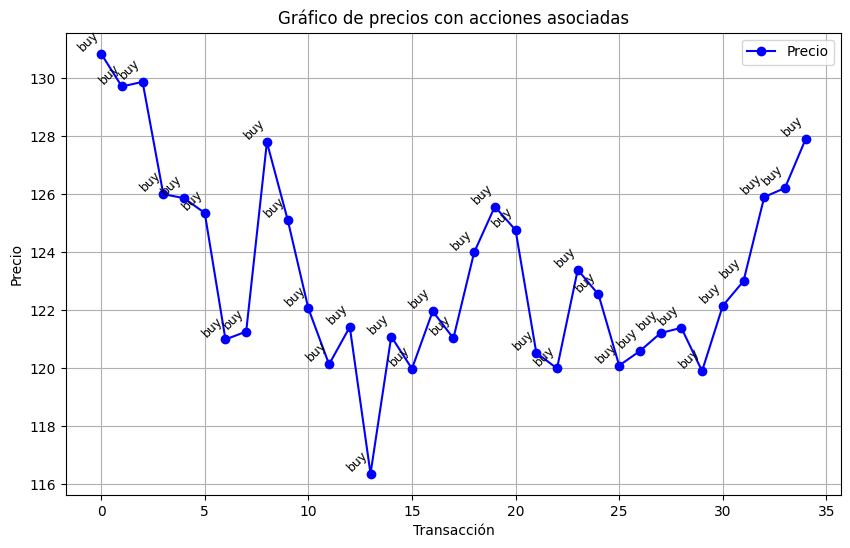

In [15]:
plot_operations_history(operations_history_1d)

### 1 Hora

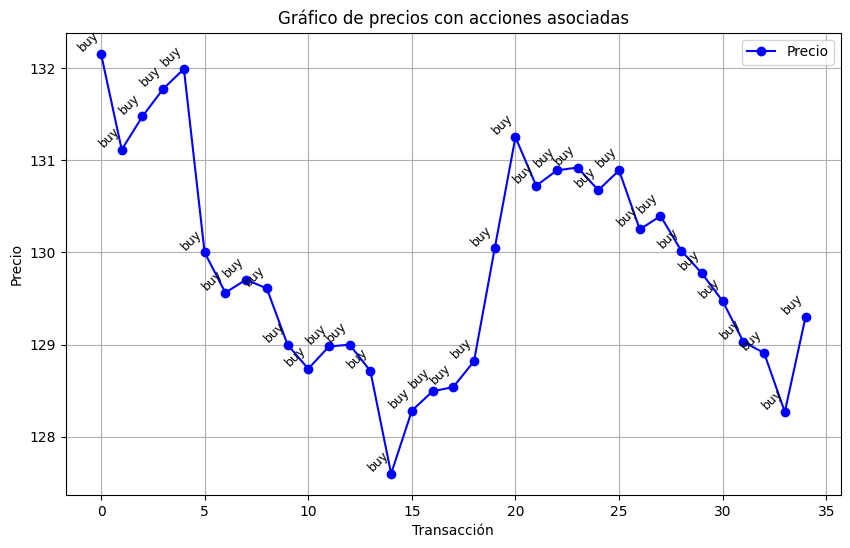

In [16]:
plot_operations_history(operations_history_1h)

### 1 Minuto

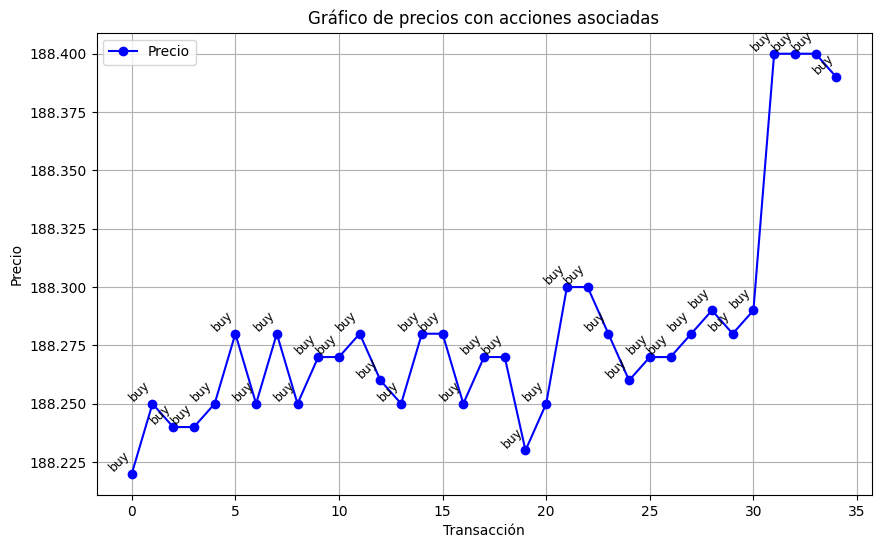

In [17]:
plot_operations_history(operations_history_1m)

### 5 Minutos

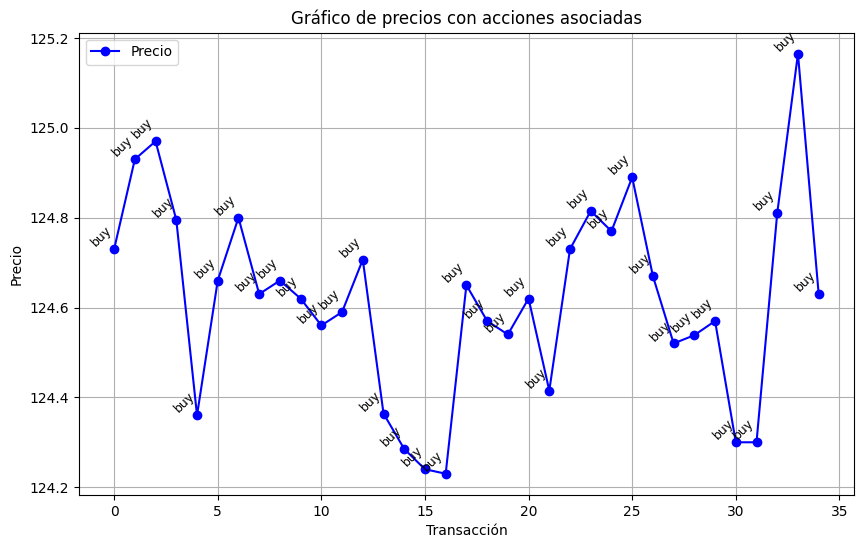

In [18]:
plot_operations_history(operations_history_5m)

## Resultados obtenidos

Para los 4 datasets obtuvimos diferentes parametros, los mejores parametros de dicho modelo para cada dataset.

## Parametros óptimos 1 día

### Señales de compra

#### SVM
- C = 0.43326595131065515
- kernel = poly
- degree = 2
- gamma = scale

#### XG BOOST
- n_estimators = 200
- max_depth = 4
- learning_rate = 0.01737000818203036
- subsample = 0.6
- colsample_bytree = 0.8

#### LOGISTIC
- penalty = l1
- C = 0.010968139046945382
- solver = saga

### Señales de venta

#### SVM
- C = 0.0035454674239493874
- kernel = rbf
- gamma = scale

#### XG BOOST
- n_estimators = 100
- max_depth = 3
- learning_rate = 0.030090107781624707
- subsample = 0.9
- colsample_bytree = 0.8

#### LOGISTIC
- penalty = l2
- C = 0.6431546383805156
- solver = liblinear

## Parametros óptimos 1 hora

### Señales de compra

#### SVM
- C = 0.04584664364591048
- kernel = poly
- degree = 2
- gamma = auto

#### XG BOOST
- n_estimators = 900
- max_depth = 9
- learning_rate = 0.2220589262776878
- subsample = 0.5
- colsample_bytree = 0.7

#### LOGISTIC
- penalty = l1
- C = 0.010968139046945382
- solver = saga

### Señales de venta

#### SVM
- C = 0.2018232497206618
- kernel = rbf
- gamma = auto

#### XG BOOST
- n_estimators = 100
- max_depth = 10
- learning_rate = 0.102602018285415
- subsample = 0.5
- colsample_bytree = 0.6

#### LOGISTIC
- penalty = l2
- C = 0.0028315415752095535
- solver = saga

## Parametros óptimos 1 minuto

### Señales de compra

#### SVM
- C = 208.31110635195978
- kernel = rbf
- gamma = auto

#### XG BOOST
- n_estimators = 200
- max_depth = 8
- learning_rate = 0.016335181464666
- subsample = 0.6
- colsample_bytree = 0.5

#### LOGISTIC
- penalty = l2
- C = 0.0015827990076342706
- solver = saga

### Señales de venta

#### SVM
- C = 89.33147882881373
- kernel = linear

#### XG BOOST
- n_estimators = 400
- max_depth = 3
- learning_rate = 0.061659645644687434
- subsample = 0.8
- colsample_bytree = 0.7

#### LOGISTIC
- penalty = l2
- C = 0.002105767490569824
- solver = saga

## Parametros óptimos 5 minutos

### Señales de compra

#### SVM
- C = 0.002176996974479978
- kernel = sigmoid
- gamma = scale

#### XG BOOST
- n_estimators = 1000
- max_depth = 9
- learning_rate = 0.014804455005781484
- subsample = 0.9
- colsample_bytree = 0.7

#### LOGISTIC
- penalty = l2
- C = 0.002395829495054093
- solver = liblinear

### Señales de venta

#### SVM
- C = 0.6739747156890435
- kernel = linear

#### XG BOOST
- n_estimators = 900
- max_depth = 9
- learning_rate = 0.08242884326336312
- subsample = 0.5
- colsample_bytree = 1.0

#### LOGISTIC
- penalty = l1
- C = 0.0030591725482995644
- solver = saga


Estos valores de parámetros se seleccionaron mediante el proceso de optimización y finetuning. XGBoost se destaca por su capacidad para manejar conjuntos de datos grandes, su eficiencia computacional y su capacidad para capturar relaciones no lineales y complejas en los datos, lo que lo hace preferible en muchas aplicaciones de aprendizaje automático.

### Parametros de los modelos

Los parámetros definidos para la estrategia de trading son fundamentales para determinar su efectividad y gestión del riesgo, los resultados obtenidos por el metodo de optuna fueron:

### 1 Dia

stop_loss: 0.899950212993615

take_profit: 1.0987292727726978

n_shares: 47

### 1 Hora

stop_loss: 0.899950212993615

take_profit: 1.0987292727726978

n_shares: 47

### 1 Minuto

stop_loss: 0.899950212993615

take_profit: 1.0987292727726978

n_shares: 47

### 5 Minutos

stop_loss: 0.899950212993615

take_profit: 1.0987292727726978

n_shares: 47


Estos valores determinan el nivel de riesgo y la rentabilidad esperada de la estrategia de trading. Un stop_loss adecuadamente ajustado puede limitar las pérdidas en caso de movimientos desfavorables del mercado, mientras que un take_profit bien definido puede asegurar las ganancias antes de que se reviertan las tendencias del mercado. La cantidad de shares define el tamaño de cada operación y su impacto en el capital inicial.

Con todo esto, pudimos obtener rendimientos que vamos a presentar un poco mas adelante, sin embargo aqui se muestran las graficas del dinero que teniamos atraves del tiempo, y la grafica del valor del portafolio atraves del tiempo tambien. Como podedmos observar ambas tienen buenos rendimientos y no bajan tanto de valor como podria asumirse con el dinero que tienes al iniciar y como va fluctuando con el tiempo.

# Valores del portafolio
El significado de esta variable, es notar como ha crecido o decrecido nuestra inversion a lo largo del tiempo, tomando un indice de 1, si esta por debajo estamos en perdidas, si esta por encima estamos en "profit".

La observación de que los volúmenes de operaciones varían según el dataset se debe a la cantidad de datos y oportunidades de entrada disponibles en cada uno. Un mayor volumen de operaciones implica más oportunidades de entrada y salida, lo que puede influir en el rendimiento.

Seria positivo analizar si existe una correlación directa entre el volumen de operaciones y el rendimiento. Un mayor volumen no garantiza necesariamente un mayor rendimiento, y viceversa. Se deben considerar otros factores como la calidad de las señales de entrada y la gestión del riesgo.

Otro punto positivo es que en los 4 datasets, notamos que nuestro valor del portafolio termino en positivo, siendo para el dataset de 5 minutos el mejor resultado, llegando casi a un 40% de aumento en el portafolio, el peor fue el dataset de 1 minuto, llegando a quedarse el mismo valor de portafolio generando poco porcentaje de rendimiento.

La similitud entre las gráficas del valor del portafolio y los movimientos del precio sugiere que la estrategia se ve favorecida por las tendencias alcistas del mercado. En este tipo de escenarios, la estrategia podría generar ganancias consistentes al aprovechar los movimientos ascendentes del precio.

Todas las graficas se parecen bastantes a los movimientos de los precios, con las mismas tendencias. Podria decirse que nuestra inversion se moveria igual que a como se mueva la accion, probablemente siendo la tendencia alcista la que beneficia nuestra estrategia.

### 1 Dia

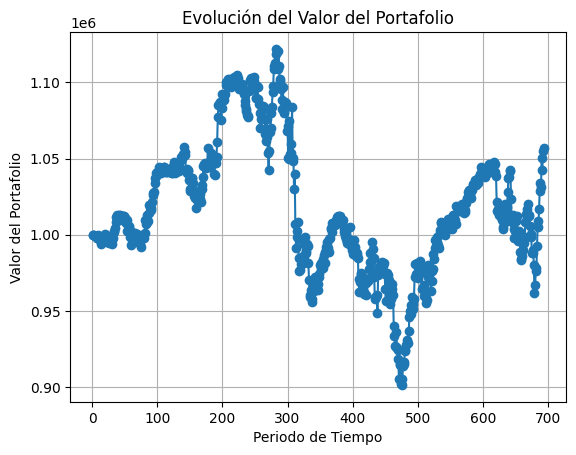

In [19]:
port_value_plot(portfolio_values_1d)

### 1 Hora

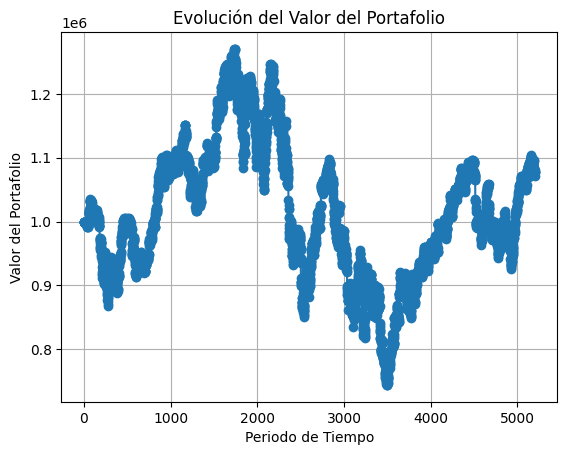

In [20]:
port_value_plot(portfolio_values_1h)

### 1 Minuto

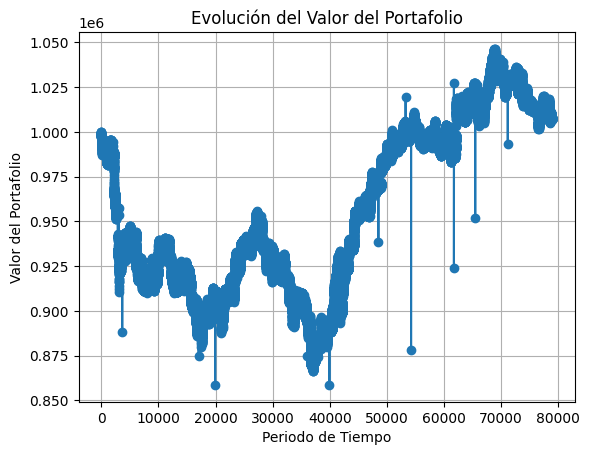

In [21]:
port_value_plot(portfolio_values_1m)

### 5 Minutos

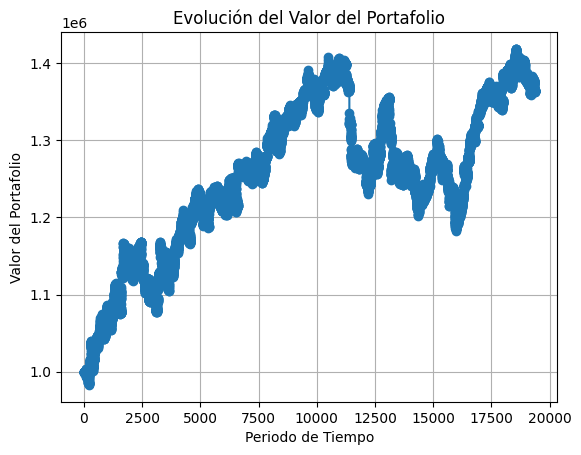

In [22]:
port_value_plot(portfolio_values_5m)

# Valores de efectivo

En las siguientes graficas podemos notar como nuestro efectivo o el dinero que no tenemos invertido crece/decrece con el tiempo.

### 1 Dia
Para este caso podemos notar como la mayoria del dinero esta siendo invertido en distintas operaciones, aumentando o disminuyendo conforme se van abriendo operaciones, llegando a estar en 20% su valor. Se va usando el efectivo de forma lateral, llegando a usarse su mayoria hasta las ultimas operaciones registradas.

El comportamiento del efectivo sugiere que la estrategia utiliza el capital de manera estratégica para maximizar las ganancias potenciales. Se invierte una cantidad significativa en operaciones, pero se mantiene un margen de efectivo disponible para cubrir posibles pérdidas y aprovechar nuevas oportunidades.

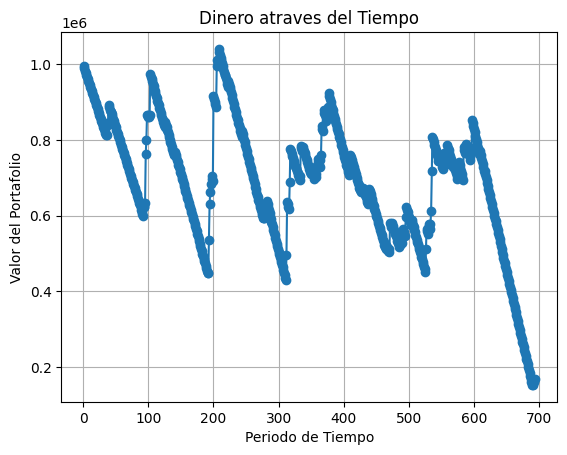

In [24]:
plot_cash(cash_values_1d)

### 1 Hora
Podemos notar que desde el principio el valor de nuestro efectivo llega a 0%, quiere decirse que se esta usando todo el dinero disponible desde que inician las operaciones, lo cual se debe a que el numero de operaciones ha aumentado con respecto a la del "time frame" de un dia.

Se tiene que tener cuidado a la hora de tener un enfoque agresivo en donde se use todo el capital, a pesar de que te pueda generar mejores ganancias potenciales, tambien podria generar un riesgo mucho mayor a la hora de hablar de "trades" perdedores.

El mayor número de operaciones en comparación con el timeframe de 1 día sugiere que la estrategia busca aprovechar al máximo las fluctuaciones del mercado a corto plazo.
 
Aun podemos notar que en algunos momentos hay un valor de efectivo considerable sin usarse.


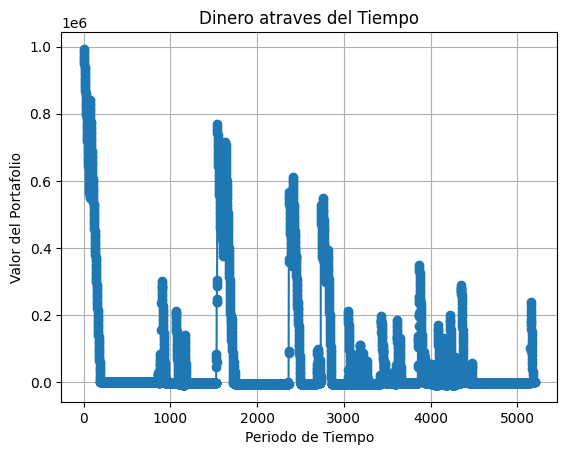

In [25]:
plot_cash(cash_values_1h)


### 1 Minuto

Nuevamente al deberse a la cantidad de operaciones que se encuentran ejecutandose desde el principio y hasta el final practicamente todo el dinero esta siendo usado en la estrategia.

Se tiene que tener cuidado a la hora de tener un enfoque agresivo en donde se use todo el capital, a pesar de que te pueda generar mejores ganancias potenciales, tambien podria generar un riesgo mucho mayor a la hora de hablar de "trades" perdedores.




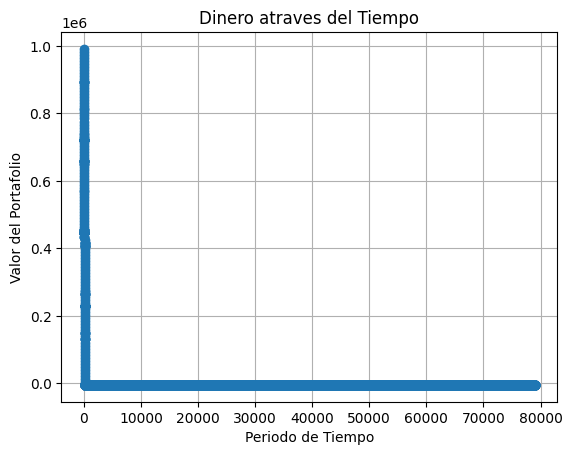

In [26]:
plot_cash(cash_values_1m)


### 5 Minutos

Podemos notar momentos en los que el efectivo no se usa, pero son en pocas ocasiones, comparandolo con los "time frames" de un dia y una hora, sin embargo, la mayor parte del tiempo el dinero es usado en su totalidad, tambien se debe al numero de operaciones hechas por el modelo.

En el "time frame" de 5 minutos, se observa un uso más estratégico del efectivo en comparación con el "time frame" de 1 minuto. La estrategia invierte y desinvierte capital de manera más dinámica, aprovechando oportunidades de mercado a corto plazo, usando una estrategia agresiva de uso de capital, pero teniendo muchos mejores resultados.

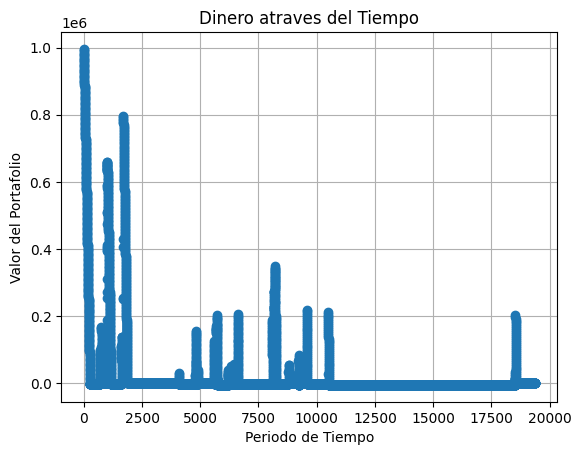

In [27]:
plot_cash(cash_values_5m)

En las siguientes graficas se hara una comparacion entre como se mueve nuestro efectivo con respecto a como nuestra inversion crece o decrece.

## 1 Dia

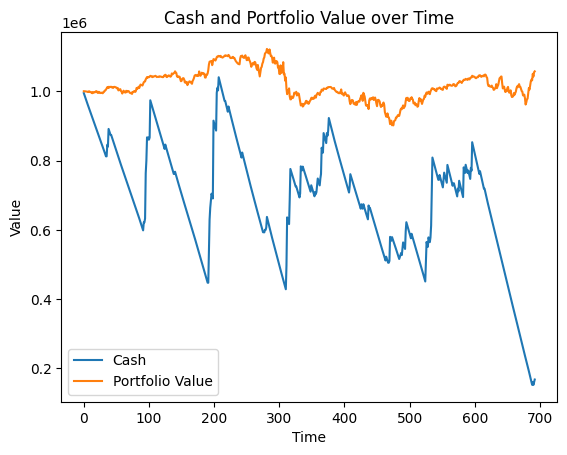

In [28]:
cash_portvalue_plot(cash_values_1d, portfolio_values_1d)

## 1 Hora

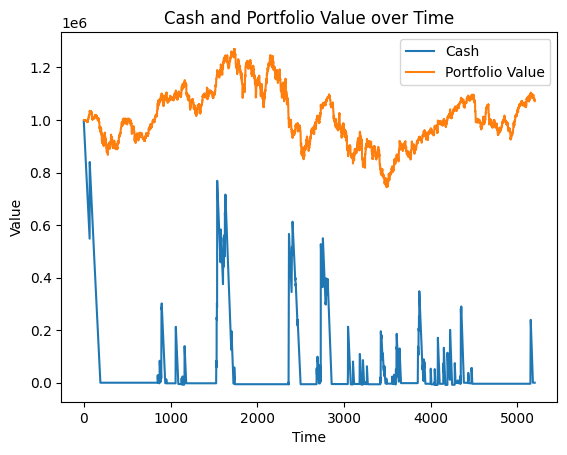

In [29]:
cash_portvalue_plot(cash_values_1h, portfolio_values_1h)

## 1 Minuto

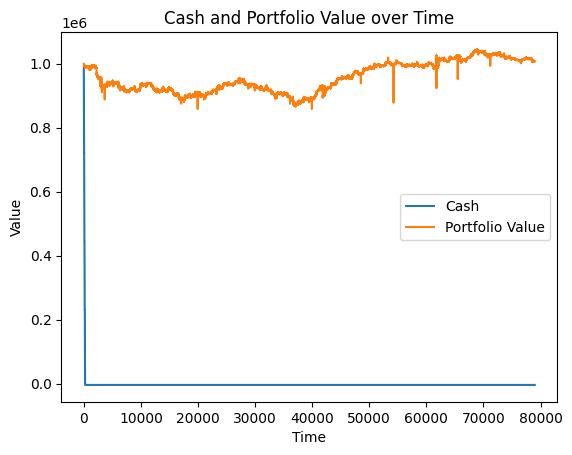

In [30]:
cash_portvalue_plot(cash_values_1m, portfolio_values_1m)

## 5 Minutos

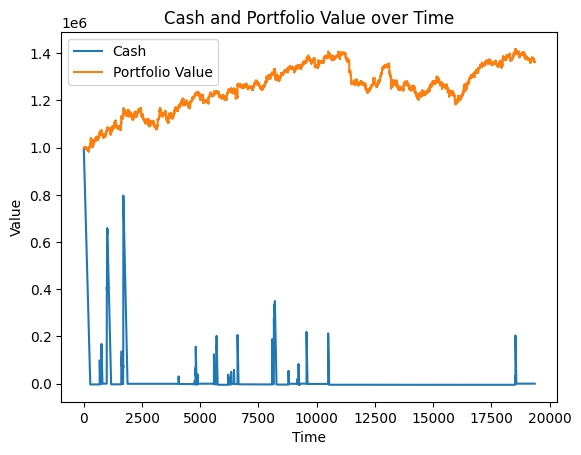

In [31]:
cash_portvalue_plot(cash_values_5m, portfolio_values_5m)

A continuacion compararemos el valor del portafolio con respecto a una estrategia pasiva (no hacer nada) para cada dataset.

### 1 Dia
El modelo inicio bien, manteniendose por encima de la estrategia pasiva, llegando a estar en un 10% de profit hasta tener una caida bastante significativa llegando a estar en niveles por debajo de la estrategia pasiva. 

Este retroceso podría deberse a varios factores, como cambios inesperados en las condiciones del mercado, errores en la ejecución de las operaciones o limitaciones de la propia estrategia.

Al final el modelo logro estar por encima, por lo que fue exitosa, consiguiendo no estar en negativo. Otra vez podemos notar que tuvo patrones similares  que el precio de cierre de la accion.

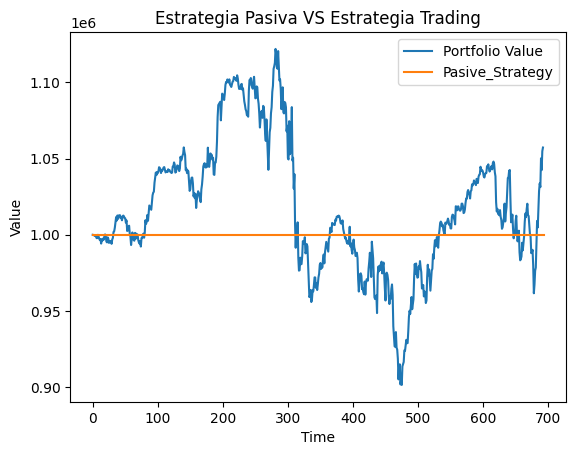

In [32]:
pasive_portvalue_plot(portfolio_values_1d)

### 1 Hora
Al tratarse de los mismos niveles de precio que el dataset de 1 dia, podemos notar patrones similares en nuestro valor del portafolio, solo que en este caso el modelo para este dataset, logro estar en un 20% de "profit" antes de la caida significativa.

Este retroceso podria deberse a varios factores, como cambios inesperados en las condiciones del mercado, errores en la ejecución de las operaciones o limitaciones de la propia estrategia.

El modelo en el "time frame" de 1 hora alcanzo un 20% de ganancias antes de la caida, superando el 10% obtenido en el timeframe de 1 día. Esto sugiere que la estrategia pudo aprovechar mejor las oportunidades de mercado a corto plazo.

Logro recuperarse de la misma manera que el de un dia, por lo que cerro en positivo, siendo mejor que no hacer nada, no aplica el dicho "mejor nada".

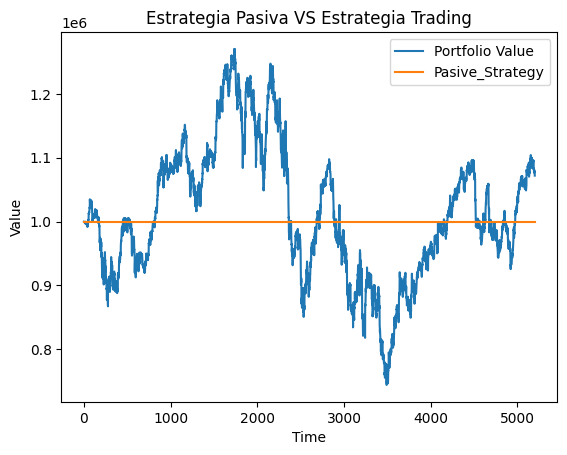

In [33]:
pasive_portvalue_plot(portfolio_values_1h)

### 1 Minuto
La mayor parte del tiempo nuestra estrategia se encontraba por debajo de la estrategia pasiva, las dificultades podrían deberse a diversos factores, como el ruido del mercado, la ejecución de operaciones a corto plazo o limitaciones en la capacidad de la estrategia para adaptarse a cambios rápidos del precio.

A pesar de las dificultades iniciales, la estrategia logró recuperarse en la parte final del dataset, superando el rendimiento de la estrategia pasiva y obteniendo un resultado positivo general. Esto indica que la estrategia pudo identificar oportunidades rentables al final del periodo, aunque no tan "jugosas".

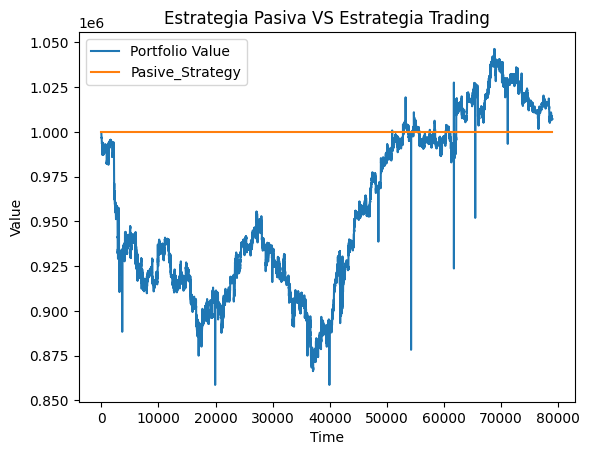

In [34]:
pasive_portvalue_plot(portfolio_values_1m)

### 5 Minutos
De nuestras estrategias esta fue la mejor, desde el inicio supero con creces la estrategia pasiva, llegando a casi un 40% de beneficio con respecto a no hacer nada, nunca estuvo por debajo de la estrategia pasiva y se mantuvo en sus maximos de beneficio al final del dataset.

A diferencia de las otras estrategias, el modelo en 5 minutos no experimentó retrocesos significativos ni estuvo por debajo de la estrategia pasiva en ningún momento. Esta consistencia y estabilidad son cualidades valiosas en una estrategia de trading.

Es probable que la estrategia tenga una alta capacidad para identificar tendencias a corto plazo y posicionarse en consecuencia, generando ganancias consistentes a lo largo del día.

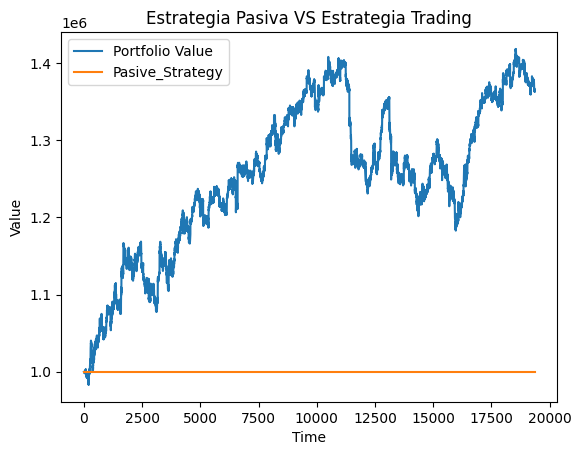

In [35]:
pasive_portvalue_plot(portfolio_values_5m)

La similitud entre los patrones del modelo y el precio de cierre de la acción sugiere que la estrategia se ve favorecida por las tendencias del mercado. En este caso, la tendencia alcista del día permitió al modelo obtener ganancias a pesar del retroceso temporal.

## Conclusiones

Los modelos probados para los "datasets" operan en situaciones de un mercado lateral tambien lo cual podria llegar a considerarse una "red flag" a menos de que se esten usando tecnicas especificas para "scalping" o tradeos por cuadricula.

Los valores de nuestros portafolios se mueven igual que el precio de la accion, por lo que los beneficios los va encontrando en medio de esta tendencia.

Los modelos se ajustan bien a los distintos "times frames", ya que mientras mas datos tienen, mas oportunidades de entrada o salida encuentran durante todo el periodo mostrado en cada uno.

Por mucho, la mejor estrategia fue la usada para el "time frame" de 5 minutos, llegando a tener casi un 40% de rendimiento mientras que las demas se mantuvieron en el rango de 1% y 11% de beneficio, por lo que podriamos pensar que hubiese sido mejor haber invertido en la tasa libre de riesgo.

Las tecnicas de backtesting y los modelos usados, no deberian usarse como la unica herramienta de un trader, si no mas bien, ser un indicador mas en su lista de herramientas para hacer "trading", todos somos buenos "traders" en un mercado alcista, por lo que no podemos tomar los resultados como la verdad absoluta.

Podemos notar que usamos 2 modelos, xg y Logistic, para el de 1 hora se combinaron los dos. Al usarse el modelo xg en varios "dataframes" podriamos argumentar tambien, que el modelo se ajusto de mejor manera a un "time frame" de 5 minutos.

Es crucial realizar pruebas exhaustivas en diferentes condiciones de mercado, incluyendo mercados bajistas y laterales, para evaluar la robustez y generalización de las estrategias.

En conclusión, las estrategias analizadas han mostrado potencial para generar retornos superiores a la inversión pasiva en mercados alcistas, habria que explorar otras situaciones de mercado.

